# Jupyter example for acquisition with `spcm`
_Spectrum Instrumentation GmbH (c)_

**1_jup_acq_single.py**

Shows a simple Standard acquisition (recording) mode example using only the few necessary commands
* connect a function generator that generates a sine wave with 10-100 kHz frequency and 200 mV amplitude to channel 0

Example for analog recording cards (digitizers) for the the M2p, M4i, M4x and M5i card-families.

_See the README file in the parent folder of this examples directory for information about how to use this example._

_See the LICENSE file for the conditions under which this software may be used and distributed._

## Import libraries
`spcm` the main library for communicating with the card. `units` sub-module from the `spcm` package for unit support. `numpy` for analysing the acquired data. `matplotlib` for plotting the acquired data.

In [1]:
import spcm
from spcm import units # spcm uses the pint library for unit handling (units is a UnitRegistry object)

import numpy as np
import matplotlib.pyplot as plt

card = None

## Open the card and setup the acquisition

Uncomment the line of code that you prefer to use:
1. if you want to open a specific card using the device identifier
1. if you want to open a remote card with ip-address
1. if you want to open a card by its serial number
1. if you want to open the first card of a specific type

In [2]:
if not card:
    # card = spcm.Card('/dev/spcm0', verbose=True).open()
    # card = spcm.Card('TCPIP::192.168.1.10::inst0::INSTR', verbose=True).open()
    # card = spcm.Card(serial_number=12345, verbose=True).open()
    card = spcm.Card(card_type=spcm.SPCM_TYPE_AI, verbose=True).open()

Python version: 3.11.9 on Windows
Driver version: 7.7.23511
Kernel version: 6.3.22848
Found '/dev/spcm0': M2p.5968-x4 sn 00060


### Setup the card to do data acquisition

For the acquisition, we set the operation mode of the card to `SPC_REC_STD_SINGLE`. For more information about this mode we refer to the specific manual of your device. The card timeout is set to 5 s, this means that if it takes longer than 5 seconds to acquire the data after the card was started there will be an interrupt and the `spcm` package will throw an `spcm.SpcmTimeout` exception.

In [3]:
card.card_mode(spcm.SPC_REC_STD_SINGLE)
timeout = card.timeout(5 * units.s)

### Setup trigger

We'll be using a channel trigger and this means that both the `OR`- and `AND`-trigger masks (see your device manual) will be set to `SPC_TMASK_NONE`.

In [4]:
trigger = spcm.Trigger(card)
trigger.or_mask(spcm.SPC_TMASK_NONE)
trigger.and_mask(spcm.SPC_TMASK_NONE);

### Setup the clock

The clock is set to using the internal oscillator with PLL to generate the required `20 MHz` sampling rate.

In [5]:
clock = spcm.Clock(card)
clock.mode(spcm.SPC_CM_INTPLL)
sample_rate = clock.sample_rate(20 * units.MHz, return_unit=units.MHz)
print(f'Used sample rate: {sample_rate:.2f}')

Used sample rate: 20.00 megahertz


### Setup the input channels

Set up the usage of one channel (Channel 0) in the range of +/- 200 mV and with an offset of 0 V. Electrical termination of the channel is set to 50 Ohm.

In [6]:
channel0, = spcm.Channels(card, card_enable=spcm.CHANNEL0)
channel0.amp(200 * units.mV);
channel0.offset(0 * units.mV);
channel0.termination(1);

### Setup the channel triggering

Setup channel triggering for channel 0 and look for a positive slope crossing the 0 volt level.

In [7]:
trigger.ch_or_mask0(channel0.ch_mask())
trigger.ch_mode(channel0, spcm.SPC_TM_POS)
trigger.ch_level0(channel0, 0 * units.mV, return_unit=units.mV);

### Initialize the buffer for data transfer from the card to the PC

Setup a buffer in RAM to save 100 microseconds of data, of which 20 microseconds are from before the trigger and 80 microsecond are from after the trigger. At 20 MS/s sampling rate this corresponds to 20000 samples.

In [8]:
data_transfer = spcm.DataTransfer(card)
data_transfer.duration(100*units.us, post_trigger_duration=80*units.us);

## Acquire the data

### Start the acquisition

The card is started and the trigger engine is enabled. This command is waiting until all the data is acquired.

In [9]:
card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_CARD_WAITREADY)
print("Finished acquiring...")

Finished acquiring...


### Start the transfer

In [10]:
data_transfer.start_buffer_transfer(spcm.M2CMD_DATA_STARTDMA, spcm.M2CMD_DATA_WAITDMA)

Starting the DMA transfer and waiting until data is in board memory
... data transfer started


### Plot the data

1. Get the horizontal time data.
1. Create a figure in Matplotlib.
1. Convert the acquired data to electrical voltages.
1. Print minimal and maximal data points. 
1. Plot the data with the trigger position at 0 and a line marking that position.

Channel 0
	Minimum: -0.2 V
	Maximum: 0.2 V


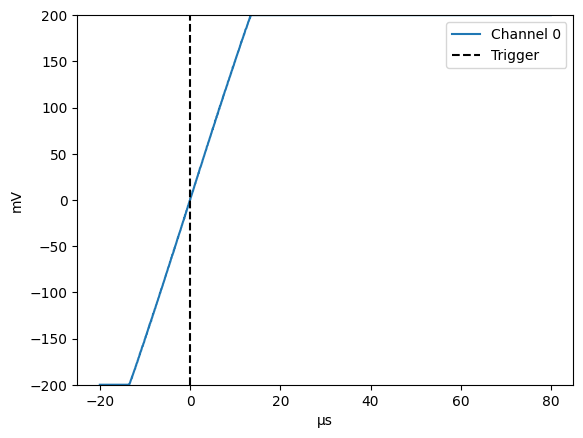

In [11]:
time_data_s = data_transfer.time_data()
fig, ax = plt.subplots()
unit_data_V = channel0.convert_data(data_transfer.buffer[channel0, :], units.V)
print(channel0)
print("\tMinimum: {:.3~P}".format(np.min(unit_data_V)))
print("\tMaximum: {:.3~P}".format(np.max(unit_data_V)))
ax.plot(time_data_s, unit_data_V, label=f"{channel0}")
ax.yaxis.set_units(units.mV)
ax.xaxis.set_units(units.us)
amplitude = channel0.amp(return_unit=units.mV)
ax.set_ylim([-channel0.amp(amplitude), channel0.amp(amplitude)])
ax.axvline(0, color='k', linestyle='--', label='Trigger')
ax.legend()
plt.show()

## Stop the card and close the connection

IMPORTANT: at the end of usage the card needs to be manually closed.

In [ ]:
if close_directly:
    card.stop()
    card.close()
    card = None
close_directly = True